## Approach 1: Logistic Regression Model

This approach builds a Logistic Regression model to predict the safety of product.

In [4]:
# Upgrade dependencies
! which python3
! pip3 install -r ../data/requirements.txt


/usr/bin/python3
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import boto3
import os
import numpy as np
import pandas as pd
import nltk, re
import time
import torch
import torch.nn as nn

from os import path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn import BCELoss
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/wenzishen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wenzishen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Reading the dataset

This approach uses the __pandas__ library to read our dataset.

#### __Training data:__

In [6]:
train_df = pd.read_csv('../data/training.csv', encoding='utf-8', header=0)
train_df.head(10)

,ID,doc_id,text,date,star_rating,title,human_tag
0,47490,15808037321,"I ordered a sample of the Dietspotlight Burn, ...",6/25/2018 17:51,1,DO NOT BUY!,0
1,16127,16042300811,This coffee tasts terrible as if it got burnt ...,2/8/2018 15:59,2,Coffee not good,0
2,51499,16246716471,I've been buying lightly salted Planters cashe...,3/22/2018 17:53,2,"Poor Quality - Burnt, Shriveled Nuts With Blac...",0
3,36725,14460351031,This product is great in so many ways. It goes...,12/7/2017 8:49,4,"Very lovey product, good sunscreen, but strong...",0
4,49041,15509997211,"My skin did not agree with this product, it wo...",3/21/2018 13:51,1,Not for everyone. Reactions can be harsh.,1
5,31679,14559274931,Mine almost burned down my house.,9/23/2017 15:01,1,One Star,1
6,8088,14552394301,Part of item is missing. Shoulder strap is mis...,9/14/2017 19:20,2,Missing shoulder strap!,0
7,22216,1739444481,"I thought I was going crazy, that I had a medi...",12/15/2017 3:36,1,Crappy Toothpaste with Too Much Chemical,1
8,37952,15743093231,heats unevenly and gets too hot too fast. easy...,6/8/2018 3:09,2,easy to burn stuff,0
9,53391,17065830021,"This is a very nice ashtray. However, I don't...",7/6/2018 22:53,4,"I purchased some 3"" mini ashtrays to fit insid...",0


#### __Test data:__

In [7]:
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', header=0)
test_df.head(10)

,ID,doc_id,text,date,star_rating,title
0,62199,15449606311,"Quality of material is great, however, the bac...",3/7/2018 19:47,3,great backpack with strange fit
1,76123,15307152511,The product was okay but wasn't refined campho...,43135.875,2,Not refined
2,78742,12762748321,I normally read the reviews before buying some...,42997.37708,1,"Doesnt work, wouldnt recommend"
3,64010,15936405041,These pads are completely worthless. The light...,43313.25417,1,The lighter colored side of the pads smells li...
4,17058,13596875291,The saw works great but the blade oiler does n...,12/5/2017 20:17,2,The saw works great but the blade oiler does n...
5,21905,15874101741,More powerful than I expected. Especially on ...,7/10/2018 17:13,4,"Keep well watered after use,has a tendency to ..."
6,78037,17029633241,We have had it for a few months and it is stil...,43233.08542,4,Great price compared to what we saw at the store
7,47695,15625164971,Blades were dull. Gave me bad face burn from ...,5/1/2018 18:40,1,Blades were dull. Gave me bad face burn from s...
8,63344,13607360001,Loved the first box I purchased from a local s...,43097.14444,2,Burnt tasting...
9,66093,17494929541,I expected better quality. The toaster burns t...,43269.53889,1,I expected better quality. The toaster burns t...


## 2. Train a Logistic Regression Model
Apply pre-processing and vectorization operations and train the model.

In [10]:
# Check the number of missing values for each columm
print(test_df.isna().sum())

ID             0
doc_id         0
text           2
date           0
star_rating    0
title          1
dtype: int64


In [11]:
# fill-in the missing values in it with the empty string
train_df["text"].fillna("", inplace=True)

In [14]:
# get a list of stop words from the NLTK library
stop = stopwords.words("english")

# Excluding useful words
excluding = [
    "against",
    "not",
    "don",
    "don't",
    "ain",
    "aren",
    "aren't",
    "couldn",
    "couldn't",
    "didn",
    "didn't",
    "doesn",
    "doesn't",
    "hadn",
    "hadn't",
    "hasn",
    "hasn't",
    "haven",
    "haven't",
    "isn",
    "isn't",
    "mightn",
    "mightn't",
    "mustn",
    "mustn't",
    "needn",
    "needn't",
    "shouldn",
    "shouldn't",
    "wasn",
    "wasn't",
    "weren",
    "weren't",
    "won",
    "won't",
    "wouldn",
    "wouldn't",
]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

# Initialize the Stemmer
snow = SnowballStemmer("english")

# Process the text for cleaning
def process_text(texts):
    final_text_list = []
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence = []
        
        # String Clearning:
        # Lowercase
        sent = sent.lower()
        # Remove leading/trailing whitespace
        sent = sent.strip()
        # Remove extra space and tabs
        sent = re.sub("\s+", " ", sent)
        # Remove HTML tags/markups:
        sent = re.compile("<.*?>").sub("", sent)

        for w in word_tokenize(sent):
            # Check if it is not numeric and its length>2 and not in stop words
            if (not w.isnumeric()) and (len(w) > 2) and (w not in stop_words):
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence)  # final string of cleaned words

        final_text_list.append(final_string)

    return final_text_list

In [32]:
# Split train and validation data
X_train, X_val, y_train, y_val = train_test_split(
    train_df[["text"]],
    train_df["human_tag"].values,
    test_size=0.10,
    shuffle=True,
    random_state=324,
)

In [33]:
# Train and Val data clean
print("Processing the text fields...")
X_train["text"] = process_text(X_train["text"].tolist())
X_val["text"] = process_text(X_val["text"].tolist())

Processing the text fields...


In [34]:
# Use TD-IDF to vectorize to vectors of len 750.
tf_idf_vectorizer = TfidfVectorizer(max_features=750)

# Fit the vectorizer to training data
tf_idf_vectorizer.fit(X_train["text"].values)

# Transform text fields
X_train = tf_idf_vectorizer.transform(X_train["text"].values).toarray()
X_val = tf_idf_vectorizer.transform(X_val["text"].values).toarray()

# Check data size
print("Shapes of features: Training and Validation")
print(X_train.shape, X_val.shape)

Shapes of features: Training and Validation
(56820, 750) (6314, 750)


In [35]:
# Store vectorized datasets for further adjustment
X_train_store = X_train.copy()
X_val_store = X_val.copy()

In [76]:
# Reassign stored data to X_train and X_val, used for second and later round model optimzation
X_train = X_train_store.copy()
X_val = X_val_store.copy()

In [77]:
# Check vectorization results
tf_idf_vectorizer.get_feature_names()[:10]

['10',
 'abl',
 'absolut',
 'acid',
 'actual',
 'ad',
 'add',
 'addit',
 'adjust',
 'advertis']

In [78]:
# Set batch numbers for each weight update
batch_size = 16
# Set epochs for total number of iterations
epochs = 30
# Set Learning rate
lr = 0.005

# Run the training in the GPU if supported, else in the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Build our double layers network
net = nn.Sequential(
    # Input size of 1 is expected. Linear layer-1 with 10 units
    nn.Linear(in_features=750, out_features=10),
    # Relu activation is applied
    nn.ReLU(),
    # Output layer with single unit
    nn.Linear(10, 1),
    # Add Sigmoid at the end to turn output to probabilities
    nn.Sigmoid(),
)
net.to(device)

# Initialize the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=1)
        nn.init.zeros_(m.bias)
net.apply(init_weights)

# Define the loss. For binary classification the appropriate choice is Binary Cross Entropy.
# For sigmoid in the last layer, use nn.BCELoss.
loss = BCELoss(reduction="none")

# Define the optimizer, SGD (Stochastic Gradient Descent) with learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Use PyTorch DataLoaders to load the data in batches
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

# Move validation dataset on CPU/GPU device
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

In [79]:
# Lists to store the losses as the training progresses
train_losses = []
val_losses = []

# Loop over epochs
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Build a training loop to train the network
    for data, target in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device).view(-1, 1)

        # Forward pass - compute the predictions of the NN on the batch
        output = net(data)  
        # Compute the loss and sum
        L = loss(output, target).sum()
        training_loss += L.item() 
        # Calculate gradients
        L.backward()  
        # Update weights with gradient descent
        optimizer.step()  

    # Get validation predictions
    val_predictions = net(X_val)
    # Calculate the validation loss
    val_loss = torch.sum(loss(val_predictions, y_val.view(-1, 1))).item()

    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)

    train_losses.append(training_loss)
    val_losses.append(val_loss)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}, Validation_loss {val_loss}, Seconds {end-start}"
    )

Epoch 0. Train_loss 0.4361748424126245, Validation_loss 0.4263160084484875, Seconds 2.069438934326172
Epoch 1. Train_loss 0.4209910346421294, Validation_loss 0.4193745885878603, Seconds 2.1273672580718994
Epoch 2. Train_loss 0.41254754592335086, Validation_loss 0.40891408693726244, Seconds 2.210697889328003
Epoch 3. Train_loss 0.40103848419771443, Validation_loss 0.395518561802146, Seconds 2.0036070346832275
Epoch 4. Train_loss 0.3880427659454794, Validation_loss 0.3816012701808481, Seconds 2.0276479721069336
Epoch 5. Train_loss 0.37559967012849754, Validation_loss 0.3691900795231826, Seconds 2.0479941368103027
Epoch 6. Train_loss 0.3648812412040748, Validation_loss 0.35916577527369736, Seconds 1.9910078048706055
Epoch 7. Train_loss 0.35615402741127555, Validation_loss 0.3511831037674216, Seconds 2.058562994003296
Epoch 8. Train_loss 0.3490215042681394, Validation_loss 0.344741642456248, Seconds 1.9767601490020752
Epoch 9. Train_loss 0.34314459500515054, Validation_loss 0.3395296229113

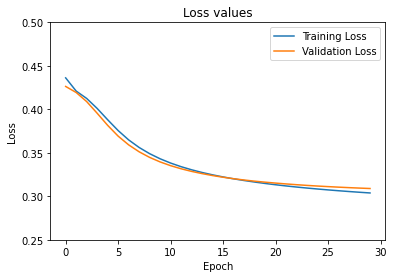

In [80]:
# Visualization
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim([0.25, 0.5])
plt.show()

## 3. Predictions

Make Predictions with test data
1. Fill-in missing values
2. Clean and normalize text
3. Vectorization
4. Convert to Torch tensor
5. Get predictions
6. Round up to 1 or down to 0

You will save your predictions (with __test_predictions__ variable) to a CSV file later in section 4.

In [85]:
# Fill-in missing values
test_df["text"].fillna("", inplace=True)

,ID,doc_id,text,date,star_rating,title
0,62199,15449606311,qualiti materi great howev backpack strang sha...,3/7/2018 19:47,3,great backpack with strange fit
1,76123,15307152511,product okay n't refin camphor adverti name bl...,43135.875,2,Not refined
2,78742,12762748321,normal read review buy someth remind alway rea...,42997.37708,1,"Doesnt work, wouldnt recommend"
3,64010,15936405041,pad complet worthless lighter color side pad s...,43313.25417,1,The lighter colored side of the pads smells li...
4,17058,13596875291,saw work great blade oiler not work adjust scr...,12/5/2017 20:17,2,The saw works great but the blade oiler does n...
...,...,...,...,...,...,...
15779,57736,16312677831,bar awesom great healthi snack remind slight b...,7/11/2018 1:24,4,Heathy all natural snack!
15780,51967,16055412641,updat increa review star compani reach make go...,2/27/2018 15:23,3,Good Company
15781,63217,16279127491,would rate star clear hemi look great sound qu...,43238.05347,2,Wish it worked as well as decribed
15782,77549,14471901971,stove great want heat hous spring summer fall ...,43101.33472,2,"Great stove, garbage fan, buy something else."


In [ ]:
# Clean and normalize text
test_df["text"] = process_text(test_df["text"].tolist())

In [86]:
# Vectorization
X_test = tf_idf_vectorizer.transform(test_df["text"].values).toarray()

# Chech vectorization results
print("Shapes of features: Training and Validation")
print(X_test.shape)

Shapes of features: Training and Validation
(15784, 750)


In [88]:
# Convert to Torch tensor
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
#Get predictions
test_predictions = net(X_test)
#Round up to 1 or down to 0
test_predictions = np.rint(test_predictions.detach().cpu().numpy())

## 4. Write predictions to a CSV file

In [89]:
import pandas as pd
 
result_df = pd.DataFrame()
result_df["ID"] = test_df["ID"]
result_df["human_tag"] = test_predictions
 
result_df.to_csv("../../data/approach_1_result.csv", encoding='utf-8', index=False)